## Multiclass classification of breast cancer patients - Notebook 1

In this notebook, I applied standard 4 ML algorithms (KNeighborsClassifier, DecisionTreeClassifier, GaussianNB, SVC) and 4 ensemble algorithms (AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier) to classify and predict the survival rate of patients with breast cancer.

### 1. Prepare Problem

In [31]:
# a) Load libraries

import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np
from numpy import mean

import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from pickle import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
# b) Load dataset
raw_data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0)
print(raw_data.shape)
print(raw_data.head(10))
print(raw_data.dtypes)

(1904, 693)
   patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
0           0             75.65             MASTECTOMY  Breast Cancer   
1           2             43.19      BREAST CONSERVING  Breast Cancer   
2           5             48.87             MASTECTOMY  Breast Cancer   
3           6             47.68             MASTECTOMY  Breast Cancer   
4           8             76.97             MASTECTOMY  Breast Cancer   
5          10             78.77             MASTECTOMY  Breast Cancer   
6          14             56.45      BREAST CONSERVING  Breast Cancer   
7          22             89.08      BREAST CONSERVING  Breast Cancer   
8          28             86.41      BREAST CONSERVING  Breast Cancer   
9          35             84.22             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal C

C:\Users\huyha\AppData\Local\Temp\ipykernel_8880\1224547202.py:2: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0)


There are 1904 attributes from 693 input fearures. One feature (death_from_cancer) is the output feature for classification.

### 2. Dataset summary

In [33]:
# a) Statistical summary
# print the statistical summary of some columns
pd.options.display.width = 100
pd.options.display.precision = 3
tempt = raw_data[0:10]
print(tempt.describe())

       patient_id  age_at_diagnosis  chemotherapy  cohort  neoplasm_histologic_grade  \
count      10.000            10.000        10.000    10.0                     10.000   
mean       13.000            68.729         0.400     1.0                      2.500   
std        11.681            17.713         0.516     0.0                      0.527   
min         0.000            43.190         0.000     1.0                      2.000   
25%         5.250            50.765         0.000     1.0                      2.000   
50%         9.000            76.310         0.000     1.0                      2.500   
75%        20.000            82.858         1.000     1.0                      3.000   
max        35.000            89.080         1.000     1.0                      3.000   

       hormone_therapy  lymph_nodes_examined_positive  mutation_count  \
count           10.000                         10.000           9.000   
mean             0.900                          2.500        

In [34]:
# On classication problems we need to know the balance or the distribution of the class attribute
class_counts = raw_data.groupby('death_from_cancer').size()
print(class_counts)

death_from_cancer
Died of Disease         622
Died of Other Causes    480
Living                  801
dtype: int64


We can see that this dataset is slightly imbalanced with high number of observations of people in Living category (801 out of 1904).

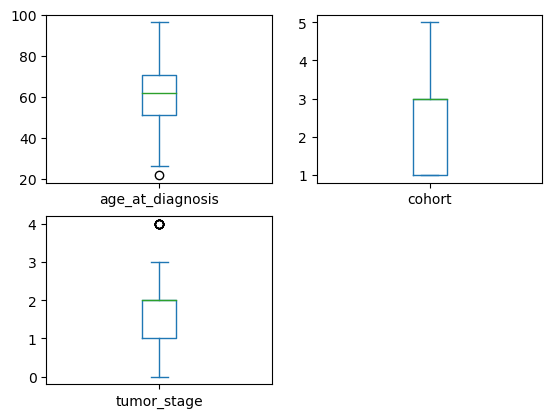

In [35]:
# b) Data visualizations

# Box and Whisker Plots of a few features
raw_plot = pd.DataFrame(raw_data, columns=["age_at_diagnosis", "cellularity", "cohort", "tumor_stage", "death_from_cancer"])
raw_plot.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

cellularity    AxesSubplot(0.125,0.712609;0.168478x0.167391)
dtype: object

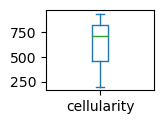

In [36]:
# Box plot for a categorial data
raw_plot['cellularity'].value_counts().plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False)

### 3. Prepare Data

In [37]:
# a) Data Cleaning
# Drop useless columns
to_keep = [i for i in range(0, 519)]
data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0, usecols=to_keep)
print(data.shape)

(1904, 519)


By doppring unimportant columns, the number of features reduces from 693 to 519.

In [38]:
# Define class for the classification class "death_from_cancer"
data['death_from_cancer'].replace({'Living': 0, 'Died of Other Causes': 1, 'Died of Disease': 2}, inplace=True)

It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [39]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['death_from_cancer']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [40]:
# Identify columns with missing values and count the number of missing values
null_cols = data.columns[data.isnull().any()]
null_count = data[null_cols].isnull().sum()

print(null_count)

type_of_breast_surgery             22
cancer_type_detailed               15
cellularity                        54
er_status_measured_by_ihc          30
neoplasm_histologic_grade          72
tumor_other_histologic_subtype     15
primary_tumor_laterality          106
mutation_count                     45
oncotree_code                      15
3-gene_classifier_subtype         204
tumor_size                         20
tumor_stage                       501
death_from_cancer                   1
dtype: int64


In [41]:
# Imputation of missing values with 'mode' values in important columns
cols_to_fill = ["type_of_breast_surgery", "cancer_type_detailed", "cellularity", "er_status_measured_by_ihc", 
                "neoplasm_histologic_grade", "tumor_other_histologic_subtype", "primary_tumor_laterality", 
                "mutation_count", "3-gene_classifier_subtype", "tumor_size", "tumor_stage"]
for col in cols_to_fill:
    data[col] = data[col].fillna(data[col].mode()[0])

In [42]:
df = data.copy(deep = True)

# Convert strings into categorial classes
cols_to_convert = ["type_of_breast_surgery", "cellularity", "er_status_measured_by_ihc", "her2_status",
                 "inferred_menopausal_state","pr_status"]

replace_dict = {"type_of_breast_surgery": {'BREAST CONSERVING': 1, 'MASTECTOMY': 0},
                "cellularity": {'High': 2, 'Moderate': 1, 'Low': 0},
                "er_status_measured_by_ihc": {'Positve': 1, 'Negative': 0},
                "her2_status": {'Positive': 1, 'Negative': 0},
                "inferred_menopausal_state": {'Post': 1, 'Pre': 0},
                "pr_status": {'Positive': 1, 'Negative': 0}}

for col in cols_to_convert:
    df[col].replace(replace_dict[col], inplace=True)

In [43]:
#Use One Hot Encoding to convert categorical features into numeric features

df = pd.get_dummies(data = df, columns = ['cancer_type','cancer_type_detailed', 'er_status', 'her2_status_measured_by_snp6', 'pam50_+_claudin-low_subtype','tumor_other_histologic_subtype', 'integrative_cluster', 'primary_tumor_laterality', '3-gene_classifier_subtype'])

In [44]:
# drop rows with missing values
df.dropna(inplace=True)
print(df.shape)

(1888, 556)


Now the dataset has been cleaned and ready for feature engineering.

In [45]:
# b) Feature Selection
# Select the top k most relevant features (largest values)
def select_features(X, y, features):
# configure to select all features
    fs = SelectKBest(score_func=f_classif, k=10)
    
# learn relationship from training data
    fs.fit(X, y)
    
    df_scores = pd.DataFrame(fs.scores_)
    df_columns = pd.DataFrame(X.columns)
    
    feature_scores = pd.concat([df_columns,df_scores], axis=1)
    feature_scores.columns = ['fname','score']
    
    best_features = feature_scores.nlargest(features,'score')
    
    X_featured = pd.DataFrame()  
    for j in best_features['fname']:
        X_featured[j] = X[j]

    X = X_featured.copy()
    X = np.array(X)    
    y = np.array(y)
    
    a = best_features['fname']
    b= best_features['score']
    
    plt.bar(a, b)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return X, y, fs

D:\Software\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


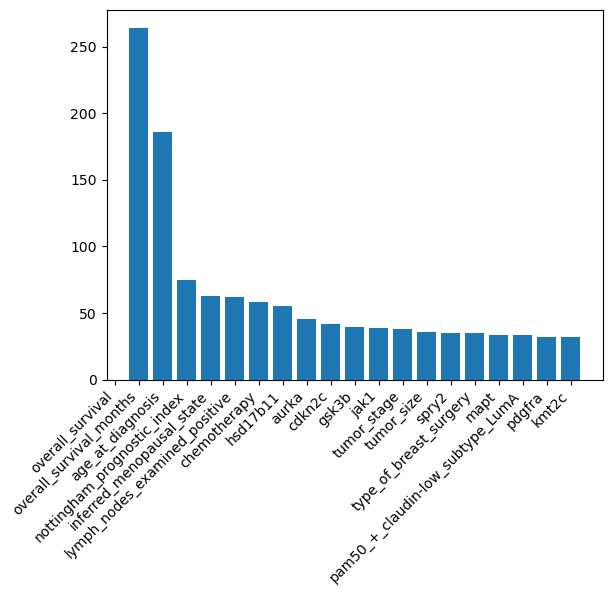

In [46]:
# c) Split the dataset into train and test sets 
X = df.drop(columns=['death_from_cancer', 'patient_id', 'oncotree_code'], axis = 1)
y = df['death_from_cancer']

X, y, fs = select_features(X, y, 20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

The chart clearly shows that 2 features (overall_survival and overall_survival_months) might be the most relevant variables.

In [47]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1416, 20) (472, 20)
(1416,) (472,)


### 4. Evaluate Algorithms

In [48]:
# a) Spot check algorithms

num_folds = 20
seed = 8
scoring = 'accuracy'

# Select 4 most popular algorithms for evaluation
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

In [49]:
# c) Compare Algorithms

results = []
alg_names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cvs = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cvs)
    alg_names.append(name)
    output = "%s: %f (%f)" % (name, cvs.mean(), cvs.std())
    print(output)

KNN: 0.825604 (0.043306)
CART: 0.796509 (0.047223)
NB: 0.815594 (0.051705)
SVM: 0.820513 (0.033755)


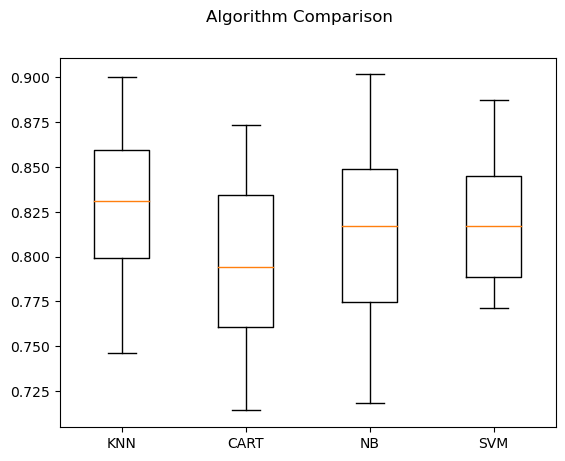

In [50]:
# Distribution of accuracy values calculated across 20 cross-validation folds.
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(alg_names)
plt.show()

In general, the training performance of these standard algorithms is quite good. As a next step, I selected the SVM model, which had the highest average score of 0.82, for further tuning.

### 5. Improve Accuracy

In [51]:
# a) Algorithm Tuning
# Define model
model = SVC(gamma='auto')

# Sensitivity parameters
c_val = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_val = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_val, kernel=kernel_val)

# Perform GridSerchCv of optimum model parameters
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.838189 using {'C': 1.3, 'kernel': 'linear'}


In [52]:
# Define model performance metrics 
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.823360 (0.032201) with: {'C': 0.1, 'kernel': 'linear'}
0.420211 (0.046208) with: {'C': 0.1, 'kernel': 'poly'}
0.757082 (0.046320) with: {'C': 0.1, 'kernel': 'rbf'}
0.752153 (0.041212) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.833260 (0.034504) with: {'C': 0.3, 'kernel': 'linear'}
0.451227 (0.066347) with: {'C': 0.3, 'kernel': 'poly'}
0.808571 (0.033152) with: {'C': 0.3, 'kernel': 'rbf'}
0.795151 (0.032353) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.836046 (0.036629) with: {'C': 0.5, 'kernel': 'linear'}
0.752153 (0.041212) with: {'C': 0.5, 'kernel': 'poly'}
0.811348 (0.036546) with: {'C': 0.5, 'kernel': 'rbf'}
0.810684 (0.032257) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.837475 (0.034598) with: {'C': 0.7, 'kernel': 'linear'}
0.751449 (0.041661) with: {'C': 0.7, 'kernel': 'poly'}
0.812757 (0.036189) with: {'C': 0.7, 'kernel': 'rbf'}
0.805020 (0.033637) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.836771 (0.036810) with: {'C': 0.9, 'kernel': 'linear'}
0.751449 (0.041661) with: {'C': 0.9, 'kernel': 

The accuracy is improved slightly from 0.82 to 0.84 by tuning model's parameters. The optimum set of parameters for this SVM model is 'C': 2, 'kernel': 'linear'.

What else can we do try to achieve a better performance?

Beside the option of tuning the model's parameters, we can test ensemble algorithms that seeks better predictive performance by combining the predictions from multiple models.

In [53]:
# b) Ensemble algorithms
# Define 4 ensemble models
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))

In [54]:
# Train and rank models using cross_val_score function
results = []
alg_names = []
for name, model1 in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cvs = cross_val_score(model1, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cvs)
    alg_names.append(name)
    msg = "%s: %f (%f)" % (name, cvs.mean(), cvs.std())
    print(msg)

AB: 0.827656 (0.045479)
GBM: 0.827575 (0.042288)
RF: 0.812103 (0.047550)
ET: 0.806449 (0.043330)


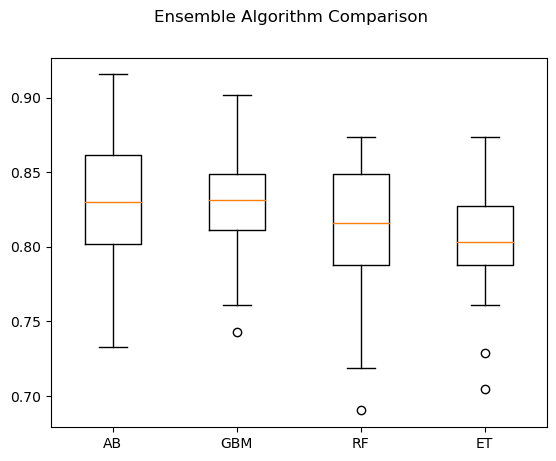

In [55]:
# Whisker and box plot of model's performances
fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(alg_names)
plt.show()

Ensemble algorithms achieved comparable prediction accuracy than it's ML counterparts. The results suggest AB model may be worthy of further study, with a strong mean and a spread that skews up towards 90s (%) in accuracy.

### 6. Finalize Model

In [56]:
# a) Predictions on validation dataset
# The GradientBoostingClassifier (GBM) showed the most promise as a low complexity and stable model for this problem
model_final = GradientBoostingClassifier()
model_final.fit(X_train, y_train)

# estimate accuracy on validation dataset
model_final.score(X_test, y_test)
y_preds = model_final.predict(X_test)

In [57]:
# Let's see the accuracy score and classification report
print(accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

0.836864406779661
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       199
         1.0       0.69      0.70      0.69       124
         2.0       0.75      0.73      0.74       149

    accuracy                           0.84       472
   macro avg       0.81      0.81      0.81       472
weighted avg       0.84      0.84      0.84       472



Overall, the prediction accuracy is above 80%, which is considered a good performance. The results suggested that F1-score is high in "Living" feature (Class 0) which had largest sample size. The opposite is true to "Died of Other Causes" (Class 1).

Text(95.72222222222221, 0.5, 'Truth')

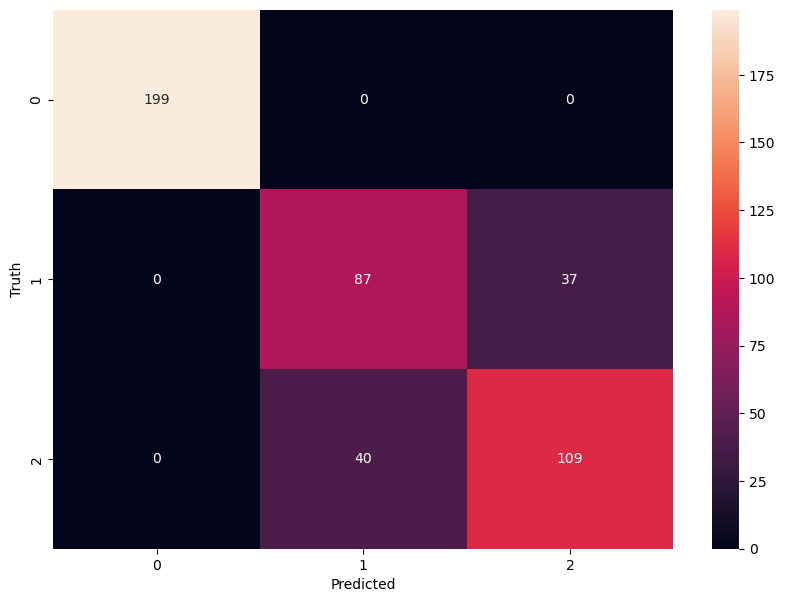

In [58]:
# Now let's visualize prediction performance on a confusion matrix in seaborn
cm_plot = tf.math.confusion_matrix(labels = y_test, predictions = y_preds)
plt.figure(figsize = (10, 7))
sn.heatmap(cm_plot, annot = True, fmt = 'd')
plt.xlabel ('Predicted')
plt.ylabel('Truth')

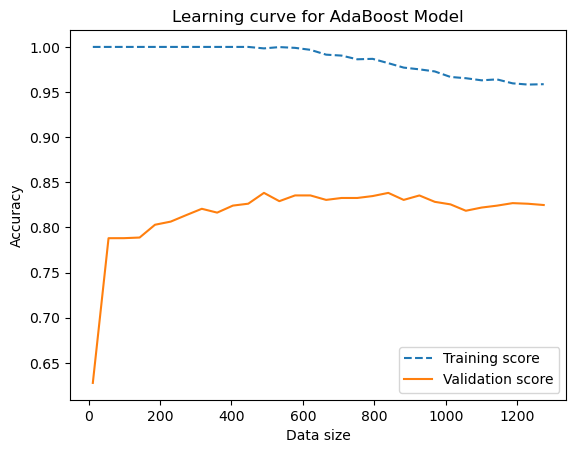

In [59]:
# Lastly, let's summarize the performance of the fit model using the learning curve

train_sizes, train_scores, test_scores = learning_curve(model_final, X_train, y_train, cv=10, train_sizes=np.linspace(0.01, 1.0, 30))

plt.plot(train_sizes,np.mean(train_scores, axis=1), '--',  label="Training score")
plt.plot(train_sizes,np.mean(test_scores, axis=1), label="Validation score")

plt.title("Learning curve for AdaBoost Model")
plt.xlabel('Data size') 
plt.ylabel('Accuracy') 
plt.legend(loc = "best")

The learning curve suggests that the model achieve high accuracy and is ready for prediction of new dataset.

In [60]:
# b) Save model for later use
filename = 'finalized_model.sav'
dump(model_final, open(filename, 'wb'))

### 7. Conclusions

- Staring with the problem statement, we performed exploratory data analysis and cleaning before passing the data into algorithms for training and prediction.

- Of the four ML algorithms, Support Vector Machine (SVM) achieved higher accuracy (0.82) than its counterparts (0.80 to 0.81). Further tuning of the SVM's model parameters lifted the prediction accuracy slightly to 0.84.

- In an attempt to imrpove the prediction performance, four ensemble algorithms were employed to train and test the dataset. The GradientBoostingClassifier (GBM) yielded comparable score to the SVM (~0.84) and it was selected to be the final model for this dataset due to its low complexibility and stability.

- The AB model produces a high validation score of 0.84 which is in line with the training score.

- What else do we have in the bucket? It's the deep learning models that we will explore in the 2nd notebook. 